In [5]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

_RE_TRAIN = re.compile(r"Training model with seed\s+(\d+)")
_RE_OVERLAP = re.compile(
    r"h\s*=\s*([0-9]*\.?[0-9]+)\s*\(([^)]+)\)\s*\|\s*Overlap\s*=\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)"
)
_RE_SAVE = re.compile(r"Model saved to:\s*.*?seed(\d+)\b")

def parse_log_text(text: str) -> pd.DataFrame:
    buffer = []          # [(h, overlap, type), ...] until we hit "Model saved ..."
    rows = []
    pending_seed = None  # fallback if a block never prints "Model saved ..."

    for raw in text.splitlines():
        line = raw.strip()
        if not line:
            continue

        m = _RE_TRAIN.search(line)
        if m:
            pending_seed = int(m.group(1))

        m = _RE_OVERLAP.search(line)
        if m:
            h = float(m.group(1))
            typ = m.group(2).strip()
            overlap = float(m.group(3))
            buffer.append((h, overlap, typ))
            continue

        m = _RE_SAVE.search(line)
        if m:
            seed = int(m.group(1))
            for h, overlap, typ in buffer:
                rows.append({"seed": seed, "h": h, "overlap": overlap, "type": typ})
            buffer.clear()
            pending_seed = None
            continue

    # If the log ends without a final "Model saved..." line, attach remaining buffered overlaps to last seen seed.
    if buffer and pending_seed is not None:
        for h, overlap, typ in buffer:
            rows.append({"seed": pending_seed, "h": h, "overlap": overlap, "type": typ})

    df = pd.DataFrame(rows, columns=["seed", "h", "overlap", "type"])
    if not df.empty:
        df = df.sort_values(["seed", "type", "h"], ignore_index=True)
    return df

def parse_log_file(path: str) -> pd.DataFrame:
    path = Path(path)
    return parse_log_text(path.read_text(encoding="utf-8", errors="replace"))

# Load
all_fid_df = parse_log_file("overlap_logs.txt").rename(columns={"type": "split"})
all_fid_df.head()


,seed,h,overlap,split
0,51,1.0,0.99990,support
1,51,1.0,0.99985,support
2,51,1.0,0.99992,support
3,51,1.0,0.99991,support
4,51,1.0,0.99994,support


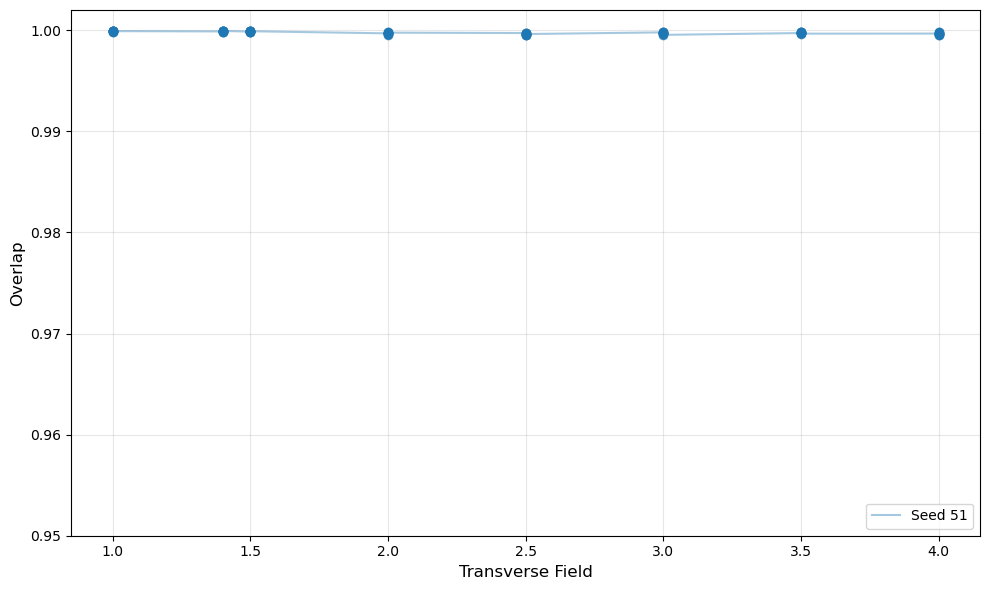

In [6]:
plt.figure(figsize=(10, 6), dpi=100)

for seed in sorted(all_fid_df["seed"].unique()):
    df_seed = all_fid_df[all_fid_df["seed"] == seed].sort_values("h")

    plt.plot(df_seed["h"], df_seed["overlap"], "-", alpha=0.4, label=f"Seed {seed}")

    support = df_seed[df_seed["split"] == "support"]
    novel = df_seed[df_seed["split"] == "novel"]

    plt.plot(
        support["h"], support["overlap"], "o",
        color="tab:blue", markersize=6,
        markerfacecolor="tab:blue", markeredgecolor="tab:blue",
        alpha=0.7
    )
    plt.plot(
        novel["h"], novel["overlap"], "d",
        color="tab:blue", markersize=6,
        markerfacecolor="white", markeredgecolor="tab:blue",
        alpha=0.7
    )

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right", fontsize=10, ncol=2)
plt.tight_layout()
plt.show()

In [7]:
stats = (
    all_fid_df
    .groupby(["h", "split"])["overlap"]
    .agg(mean="mean", std="std")
    .reset_index()
)

stats["std"] = stats["std"].fillna(0.0)

stats.sort_values(["h", "split"]).head(20)

,h,split,mean,std
0,1.0,support,0.999909,0.000031
1,1.4,support,0.999896,0.000032
2,1.5,support,0.999876,0.000042
3,2.0,support,0.999710,0.000094
4,2.5,support,0.999626,0.000087
5,3.0,support,0.999715,0.000074
6,3.5,support,0.999767,0.000059
7,4.0,support,0.999673,0.000080


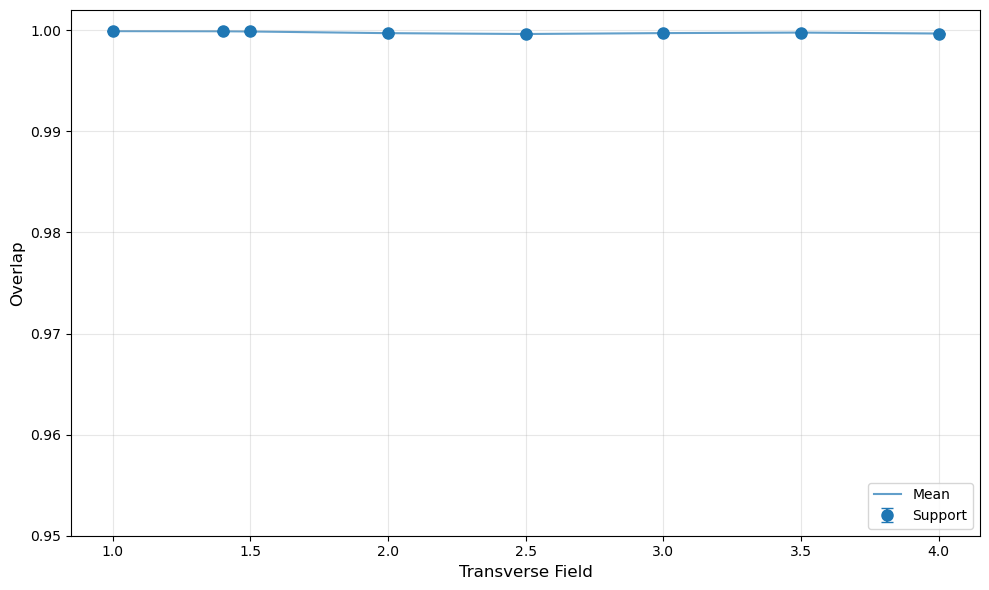

In [8]:
plt.figure(figsize=(10, 6), dpi=100)

stats_sorted = stats.sort_values("h")

for split in ["support", "novel"]:
    s = stats_sorted[stats_sorted["split"] == split]
    if s.empty:
        continue

    if split == "support":
        plt.errorbar(
            s["h"], s["mean"], yerr=s["std"],
            fmt="o", color="tab:blue", markersize=8,
            markerfacecolor="tab:blue", markeredgecolor="tab:blue",
            capsize=4, label="Support"
        )
    else:
        plt.errorbar(
            s["h"], s["mean"], yerr=s["std"],
            fmt="d", color="tab:blue", markersize=8,
            markerfacecolor="white", markeredgecolor="tab:blue",
            capsize=4, label="Novel"
        )

plt.plot(
    stats_sorted["h"], stats_sorted["mean"],
    "-", color="tab:blue", alpha=0.7, zorder=0, label="Mean"
)

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower right", fontsize=10)

plt.tight_layout()
plt.show()


In [11]:
from datetime import datetime
from pathlib import Path

results_err_dir = Path("results_error")
results_err_dir.mkdir(parents=True, exist_ok=True)

# Build the export dataframe: h, overlap, overlap_err
overlap_df = (
    stats.loc[:, ["h", "mean", "std"]]
    .rename(columns={"mean": "overlap", "std": "overlap_err"})
    .sort_values("h", ignore_index=True)
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"tfim_3x3_overlap_err_{timestamp}.csv"
save_path = results_err_dir / file_name

overlap_df.to_csv(save_path, index=False)
print(f"Overlap data saved to: {save_path}")

Overlap data saved to: results_error/tfim_3x3_overlap_err_20260123_090328.csv
